# Burst Cut v2 Analysis
Analysis of a new type of burst cut in R68 data

In [1]:
import numpy as np
from matplotlib.pyplot import *
from tqdm import tqdm_notebook

In [2]:
#*    Row   *   PTOFkeV * in50_1000 * dN_50_100 * dN_50_100 *
RQ_names=['Entry','PTOFkeV','in50_1000', 'dN_pre', 'dN_post']
data_types=['bkg','Na','PuBe']
data={'bkg':{},'Na':{},'PuBe':{}}

for dtype in data_types:
    with open(f'data/r68_n125_{dtype}_cok_2keV.txt', "r") as text:
        lines=np.array([np.array(line.replace("*","").split()).astype(np.float) for line in text.readlines()[3:-2]])
        data[dtype]['lines']=lines
        data[dtype]['Nevents']=len(lines)
        for i,RQ in enumerate(RQ_names):
            data[dtype][RQ]=lines[:,i]
        data[dtype]['in50_1000']=data[dtype]['in50_1000'].astype(bool)

In [3]:
#PMF of finding a gap of size dN
#Here, we're assuming dN>=1, in accordance with the definition of dN that we used
from scipy.optimize import curve_fit
def fPMF(dN,A,p):
    return A*p*(1-p)**(dN-1)

In [272]:
#Fitting routine using bootstrap method to estimate parameter uncertainties
#Stolen from: https://stackoverflow.com/questions/14581358/getting-standard-errors-on-fitted-parameters-using-the-optimize-leastsq-method-i
#Modified to just use yerr instead of stdev of residuals since residuals are x-dependent
from scipy import optimize
def fit_bootstrap(function, datax, datay, sigmay, p0, Nsigma=1, Nsim=100):

    errfunc = lambda p, x, y, sigy: (function(x,*p) - y)/sigy

    # Fit first time
    pfit, perr = optimize.leastsq(errfunc, p0, args=(datax, datay, sigmay), full_output=0)
    #pfit, pcov = curve_fit(function, datax, datay, p0=p0)


    # Get the stdev of the residuals
    #residuals = errfunc(pfit, datax, datay)
    #sigma_res = np.std(residuals)

    #sigma_err_total = np.sqrt(sigma_res**2 + yerr_systematic**2)

    # Nsim random data sets are generated and fitted
    ps = []
    for i in range(Nsim):

        #randomDelta = np.random.normal(0., sigma_err_total, len(datay))
        randomDelta = np.random.normal(0., sigmay)
        randomdataY = datay + randomDelta

        randomfit, randomcov = \
            optimize.leastsq(errfunc, p0, args=(datax, randomdataY,sigmay),\
                             full_output=0)
        #randomfit, randomcov  = curve_fit(function, datax, datay, p0=p0)

        ps.append(randomfit) 

    ps = np.array(ps)
    mean_pfit = np.mean(ps,0)
    err_pfit = Nsigma * np.std(ps,0) 

    return mean_pfit, err_pfit

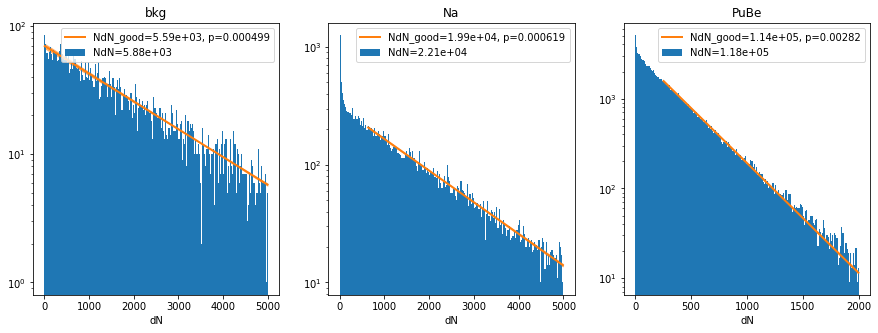

In [479]:
fig,axs=subplots(1,3,figsize=(15,5))

binss=[np.linspace(0,5e3,201),np.linspace(0,5e3,201),np.linspace(0,2e3,201)]
cfits=[(bctr>1) & (bctr<5e3), (bctr>250), (bctr>250)]

for dtype,ax,bins,cfit in zip(data_types,axs,binss,cfits):
    c,b,_=ax.hist(data[dtype]['dN_pre'][data[dtype]['in50_1000']],bins=bins,label=f"NdN={np.sum(data[dtype]['in50_1000']):.3g}");
    bctr=(b[:-1]+b[1:])/2
    ax.set_yscale('log')
    ax.set_xlabel('dN')
    ax.set_title(dtype)
    
    
    #pmf
    popt,pcov=curve_fit(fPMF,bctr[cfit],c[cfit],p0=[1e3,1e-3])
    perr=np.sqrt(np.diag(pcov))

    data[dtype]['popt']=popt
    data[dtype]['perr']=perr
    data[dtype]['p']=popt[1]
    data[dtype]['dp']=perr[1]
    data[dtype]['NdN']=np.sum(data[dtype]['in50_1000'])
    data[dtype]['NdN_good']=popt[0]/(b[1]-b[0])
    data[dtype]['dNdN_good']=perr[0]/(b[1]-b[0])

    ax.fill_between(bctr[cfit],fPMF(bctr[cfit],popt[0]+perr[0], popt[1]+perr[1]),
                 fPMF(bctr[cfit],popt[0]-perr[0], popt[1]-perr[1]),color='C1',alpha=0.5)
    ax.plot(bctr[cfit],fPMF(bctr[cfit],*popt),linewidth=2,label=f"NdN_good={data[dtype]['NdN_good']:.3g}, p={popt[1]:.3g}")
    '''
    #Enk
    popt,pcov=curve_fit(Enk,bctr[cfit],c[cfit],p0=[1e-3,np.sum(data['bkg']['in50_1000'])/1e-3]) #p,N
    perr=np.sqrt(np.diag(pcov))

    data[dtype]['popt']=popt
    data[dtype]['perr']=perr
    data[dtype]['p']=popt[0]
    data[dtype]['dp']=perr[0]
    data[dtype]['NdN']=np.sum(data[dtype]['in50_1000'])
    data[dtype]['NdN_good']=popt[0]*popt[1]/(b[1]-b[0])
    data[dtype]['dNdN_good']=(popt[0]*popt[1]*np.sqrt((perr[0]/popt[0])**2+(perr[1]/popt[1])**2))/(b[1]-b[0])

    ax.fill_between(bctr[cfit],Enk(bctr[cfit],popt[0]+perr[0], popt[1]+perr[1]),
                 Enk(bctr[cfit],popt[0]-perr[0], popt[1]-perr[1]),color='C1',alpha=0.5)
    ax.plot(bctr[cfit],Enk(bctr[cfit],*popt),linewidth=2,label=f"p={data[dtype]['p']:.3g}, NdN_good={data[dtype]['NdN_good']:.3g}")
    '''
    ax.legend()

In [480]:
print('Type\tpopt[0]\t\t+/-\t\tpopt[1]\t\t+/-')
for dtype in data_types:
    print(f"{dtype}:\t{data[dtype]['popt'][0]:.3E}\t{data[dtype]['perr'][0]:.3E}\t{data[dtype]['popt'][1]:.3E}\t{data[dtype]['perr'][1]:.3E}")

Type	popt[0]		+/-		popt[1]		+/-
bkg:	1.397E+05	2.300E+03	4.991E-04	1.193E-05
Na:	4.963E+05	3.611E+03	6.186E-04	9.325E-06
PuBe:	1.139E+06	3.383E+03	2.816E-03	1.551E-05


In [481]:
#How many total, good, and bad dNs do we think are in there?
print('Type\tNdN_tot\t\tNdN_good\t+/-\t\tNdN_bad\t\tf_bad\t\t+/-')
for dtype in data_types:
    line=f"{dtype}:\t"
    line+=f"{data[dtype]['NdN']:8.0f}\t"
    #line+=f"{data[dtype]['NdN_good']:8.1f}\t{data[dtype]['NdN_good']*data[dtype]['perr'][0]/data[dtype]['popt'][0]:.1f}\t\t"
    line+=f"{data[dtype]['NdN_good']:8.1f}\t{data[dtype]['dNdN_good']:.1f}\t\t"
    line+=f"{data[dtype]['NdN']-data[dtype]['NdN_good']:.1f}\t\t"
    line+=f"{1-data[dtype]['NdN_good']/data[dtype]['NdN']:.3f}\t\t"
    #line+=f"{data[dtype]['NdN_good']*data[dtype]['perr'][0]/data[dtype]['popt'][0]/data[dtype]['NdN']:.3f}"
    line+=f"{data[dtype]['dNdN_good']/data[dtype]['NdN']:.3f}\t\t"
    print(line)

Type	NdN_tot		NdN_good	+/-		NdN_bad		f_bad		+/-
bkg:	    5879	  5586.1	92.0		292.9		0.050		0.016		
Na:	   22081	 19853.4	144.4		2227.6		0.101		0.007		
PuBe:	  118203	113875.3	338.3		4327.7		0.037		0.003		


In [482]:
#Why is bkg now predicting a bunch of bad dNs? The ROOT fit from 0-1k was consistent with 0.
#I guess it was just a (lucky) garbage fit in ROOT since bkg has almost no stats below dN=1k.
#Still, would be comforting for this to show 0 bad guys in bkg.

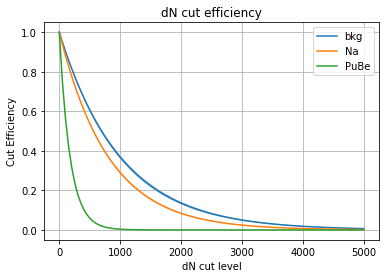

In [483]:
#Cut effects
import math
def dNeff(dN,p):
    return (1-p)**(2*(dN-1)+2)
def eff2dN(eff,p):
    return 0.5*math.log(eff,1-p)

#dNs=np.logspace(0,4,100)
dNs=np.linspace(0,5000,100)
for dtype in data_types:
    fill_between(dNs,dNeff(dNs,data[dtype]['p']+data[dtype]['dp']),
                 dNeff(dNs,data[dtype]['p']-data[dtype]['dp']),alpha=0.5)
    plot(dNs,dNeff(dNs,data[dtype]['p']),label=dtype)
    
#Simulate cut with PuBe
#dns=np.diff(np.where(np.random.random(int(1e6))<ps[2])[0])
#plot(ks,[np.sum((dns[:-1]>ki) & (dns[1:]>ki))/len(dns[1:]) for ki in ks],'--',label='sim')
#Looks good!

legend()
title('dN cut efficiency')
xlabel('dN cut level')
#xscale('log')
ylabel('Cut Efficiency')
#yscale('log')
grid()

In [494]:
#Ebins=np.linspace(50,500,181)
Ebins=np.linspace(50,500,91)
Ebctr=(Ebins[:-1]+Ebins[1:])/2
#eff_target=np.linspace(1,0,11)[:-1]
#eff_target=np.linspace(1,0.5,21)
eff_target=np.linspace(1,0.5,41)
print(eff_target)
for dtype in tqdm_notebook(data_types):
    data[dtype]['dN_cuts']=[]
    data[dtype]['dN_Npass']=[]
    data[dtype]['cs']=[]
    for eff in eff_target:
        #Pick the dN cut level
        if eff==1:
            dN_cut=-1
        else:
            dN_cut=eff2dN(eff,data[dtype]['p'])
            
        data[dtype]['dN_cuts'].append(dN_cut)
        cut=(data[dtype]['in50_1000']==1) & (data[dtype]['dN_pre']>dN_cut) & (data[dtype]['dN_post']>dN_cut)
        data[dtype]['dN_Npass'].append(np.sum(cut))
        c,b=np.histogram(1e3*data[dtype]['PTOFkeV'][cut],bins=Ebins);
        data[dtype]['cs'].append(c)
    
    data[dtype]['dN_cuts']=np.array(data[dtype]['dN_cuts'])
    data[dtype]['dN_Npass']=np.array(data[dtype]['dN_Npass'])
    data[dtype]['cs']=np.array(data[dtype]['cs'])

[1.     0.9875 0.975  0.9625 0.95   0.9375 0.925  0.9125 0.9    0.8875
 0.875  0.8625 0.85   0.8375 0.825  0.8125 0.8    0.7875 0.775  0.7625
 0.75   0.7375 0.725  0.7125 0.7    0.6875 0.675  0.6625 0.65   0.6375
 0.625  0.6125 0.6    0.5875 0.575  0.5625 0.55   0.5375 0.525  0.5125
 0.5   ]


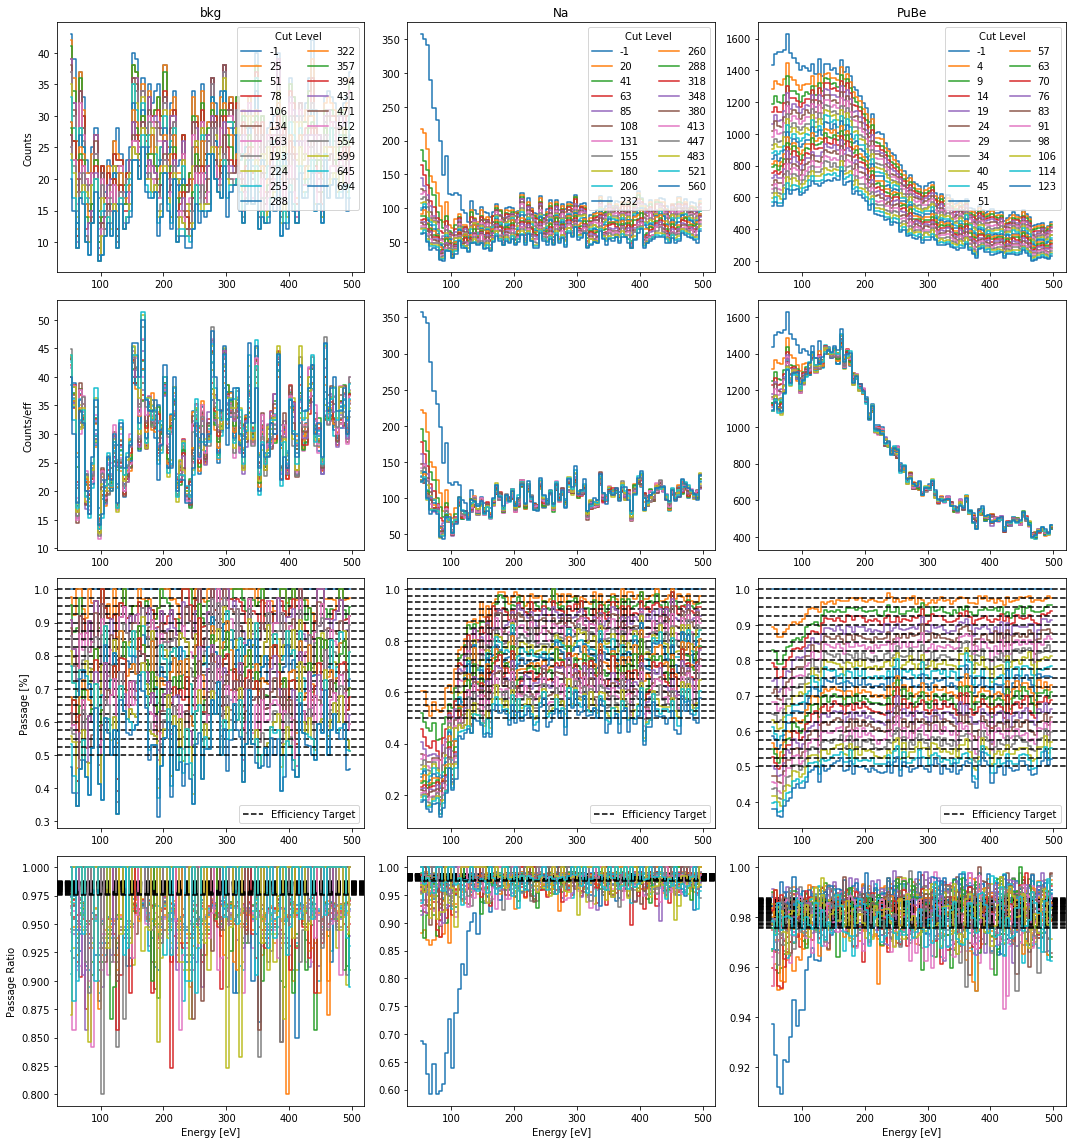

In [495]:
fig,axs=subplots(4,3,figsize=(15,16))

for itype,dtype in enumerate(data_types):
    #Count hists
    #for c,dNc,eff in zip(data[dtype]['cs'],data[dtype]['dN_cuts'],eff_target):
    for i in range(len(data[dtype]['cs']))[::2]:
        c=data[dtype]['cs'][i]
        dNc=data[dtype]['dN_cuts'][i]
        eff=eff_target[i]
        axs[0,itype].step(Ebctr,c,where='mid',label=f'{dNc:.0f}')#label=f'{eff:.1f}')

        #Rescaled by efficiency
        axs[1,itype].step(Ebctr,c/eff,where='mid',label=f'{dNc:.0f}')#label=f'{eff:.1f}')
    
        #Passage and efficiency target
        axs[2,itype].step(Ebctr,c/data[dtype]['cs'][0],where='mid')#,label=f'{dNc:.0f}')#label=f'{eff:.1f}')
        axs[2,itype].axhline(eff,color='k',linestyle='--',label='Efficiency Target')
        if i==0:
            axs[2,itype].legend(loc='lower right')
    
    axs[0,itype].set_title(dtype)
    axs[0,itype].legend(ncol=2,title='Cut Level',loc='upper right')
    #axs[2,itype].set_xlabel('Energy [eV]')
    
    #Relative hist ratios
    for i in range(len(data[dtype]['dN_cuts'])-1):
        axs[3,itype].step(Ebctr,data[dtype]['cs'][i+1]/data[dtype]['cs'][i],where='mid',label=f'{i:.0f}')#label=f'{eff:.1f}')
        axs[3,itype].axhline(eff_target[i+1]/eff_target[i],color='k',linestyle='--')
    
    axs[3,itype].set_xlabel('Energy [eV]')
    
axs[0,0].set_ylabel('Counts')
axs[1,0].set_ylabel('Counts/eff')
axs[2,0].set_ylabel('Passage [%]')
axs[3,0].set_ylabel('Passage Ratio')
tight_layout()

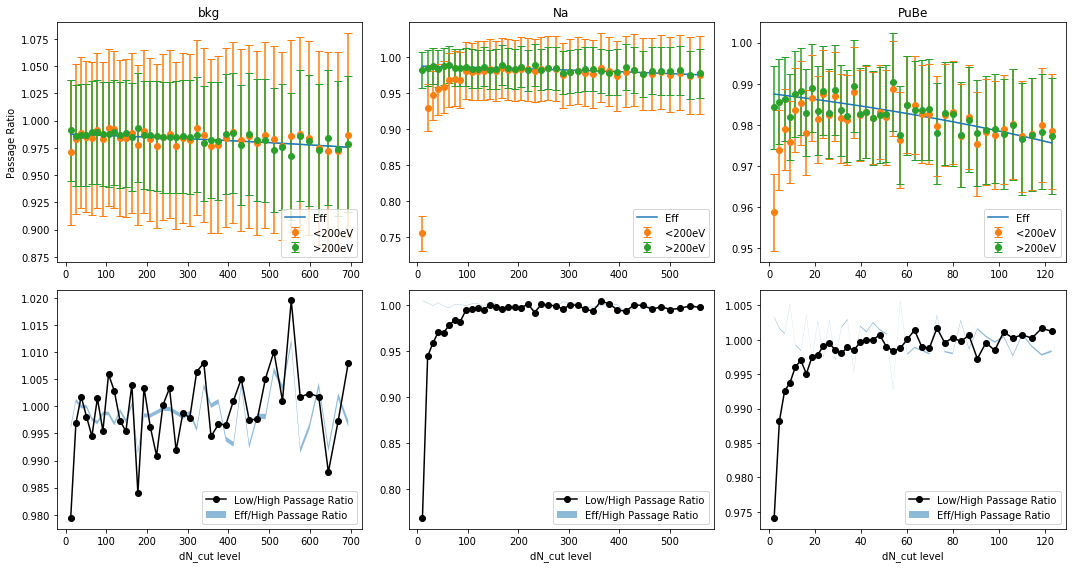

In [496]:
fig,axs=subplots(2,3,figsize=(15,8))
#Compare hist ratios to passage fractions
for itype,dtype in enumerate(data_types):
    
    #Eff ratio
    axs[0,itype].plot(data[dtype]['dN_cuts'][1:],eff_target[1:]/eff_target[:-1],label='Eff')
    
    eff_hi=dNeff(np.array(data[dtype]['dN_cuts']),data[dtype]['popt'][1]+data[dtype]['perr'][1])
    eff_low=dNeff(np.array(data[dtype]['dN_cuts']),data[dtype]['popt'][1]-data[dtype]['perr'][1])
    eff_hi[0]=1 #These have no cuts
    eff_low[0]=1
    axs[0,itype].fill_between(data[dtype]['dN_cuts'][1:],
                            eff_hi[1:]/eff_hi[:-1],
                            eff_low[1:]/eff_low[:-1],alpha=0.5)
                    
    #hratio=np.mean(data[dtype]['cs'][1:],axis=1)/np.mean(data[dtype]['cs'][:-1],axis=1)
    #axs[itype].plot(data[dtype]['dN_cuts'][1:],hratio,'o',label='all')
    
    cut=Ebctr<200
    hratio_low=[ np.sum(data[dtype]['cs'][i+1][cut])/np.sum(data[dtype]['cs'][i][cut]) for i in range(len(data[dtype]['cs'][1:])) ]
    dhratio_low=[ hratio_low[i]*(1/np.sqrt(np.sum(data[dtype]['cs'][i+1][cut]))+1/np.sqrt(np.sum(data[dtype]['cs'][i][cut]))) for i in range(len(data[dtype]['cs'][1:])) ]
    #axs[itype].plot(data[dtype]['dN_cuts'][1:],hratio,'o',label='<200eV')
    axs[0,itype].errorbar(data[dtype]['dN_cuts'][1:],hratio_low,yerr=dhratio_low,
                        fmt='o',capsize=4,label='<200eV')
    
    cut=Ebctr>200
    hratio_hi=[ np.sum(data[dtype]['cs'][i+1][cut])/np.sum(data[dtype]['cs'][i][cut]) for i in range(len(data[dtype]['cs'][1:])) ]
    dhratio_hi=[ hratio_hi[i]*(1/np.sqrt(np.sum(data[dtype]['cs'][i+1][cut]))+1/np.sqrt(np.sum(data[dtype]['cs'][i][cut]))) for i in range(len(data[dtype]['cs'][1:])) ]
    #axs[itype].plot(data[dtype]['dN_cuts'][1:],hratio,'o',label='>200eV')
    axs[0,itype].errorbar(data[dtype]['dN_cuts'][1:],hratio_hi,yerr=dhratio_hi,
                        fmt='o',capsize=4,label='>200eV')
       
    axs[0,itype].set_title(dtype)
    #axs[0,itype].set_ylim(0.4,1)
    axs[0,itype].legend(loc='lower right')
    
    #Low/High passage ratio
    axs[1,itype].plot(data[dtype]['dN_cuts'][1:],np.array(hratio_low)/np.array(hratio_hi),'-ok',label='Low/High Passage Ratio')
    axs[1,itype].fill_between(data[dtype]['dN_cuts'][1:],
                        (eff_hi[1:]/eff_hi[:-1])/np.array(hratio_hi),
                        (eff_low[1:]/eff_low[:-1])/np.array(hratio_hi),alpha=0.5, label='Eff/High Passage Ratio')
    axs[1,itype].set_xlabel('dN_cut level')
    axs[1,itype].legend(loc='lower right')

axs[0,0].set_ylabel('Passage Ratio')

tight_layout()

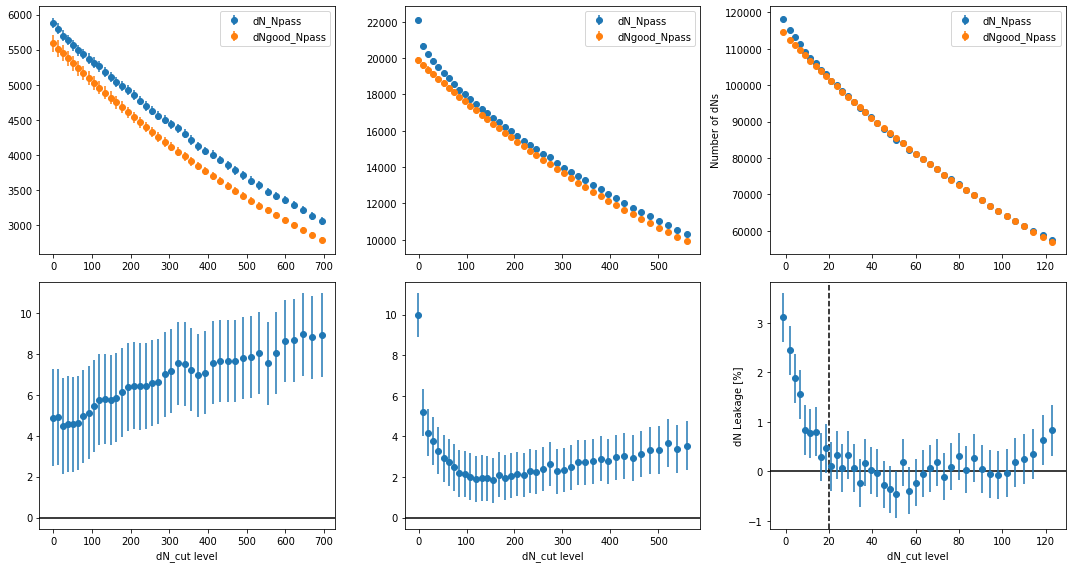

In [558]:
#Estimated leakage
fig,axs=subplots(2,3,figsize=(15,8))
for itype,dtype in enumerate(data_types):
    dNgood_Npass=data[dtype]['NdN_good']*dNeff(data[dtype]['dN_cuts'],data[dtype]['p'])
    ArelErr=data[dtype]['perr'][0]/data[dtype]['popt'][0]
    dNgood_Npass_low=data[dtype]['NdN_good']*(1-ArelErr)*dNeff(data[dtype]['dN_cuts'],data[dtype]['p']-data[dtype]['dp'])
    dNgood_Npass_hi=data[dtype]['NdN_good']*(1+ArelErr)*dNeff(data[dtype]['dN_cuts'],data[dtype]['p']+data[dtype]['dp'])
    
    #Combine stat and fit uncertainties
    ddNgood_Npass_stat = np.sqrt(data[dtype]['NdN_good'])*dNeff(data[dtype]['dN_cuts'],data[dtype]['popt'][1])
    ddNgood_Npass_fit = np.abs(dNgood_Npass_hi-dNgood_Npass_low)/2#Make it symmetric
    ddNgood_Npass = np.sqrt(ddNgood_Npass_stat**2 + ddNgood_Npass_fit**2)
    
    axs[0,itype].errorbar(data[dtype]['dN_cuts'],data[dtype]['dN_Npass'],yerr=np.sqrt(data[dtype]['dN_Npass']),
                      fmt='o',label='dN_Npass')
    axs[0,itype].errorbar(data[dtype]['dN_cuts'],dNgood_Npass,yerr=ddNgood_Npass,
                          fmt='o',label='dNgood_Npass')
    axs[0,itype].legend()
    
    #Leakage fraction
    fleak=100*(data[dtype]['dN_Npass']-dNgood_Npass)/data[dtype]['dN_Npass']
    dfleak=100*dNgood_Npass/data[dtype]['dN_Npass']*np.sqrt( (ddNgood_Npass/dNgood_Npass)**2 + (1/data[dtype]['dN_Npass']) )
    axs[1,itype].errorbar(data[dtype]['dN_cuts'],fleak,yerr=dfleak,fmt='o',label='leakage')
    #axs[1,itype].set_ylim(0,25)
    axs[1,itype].axhline(0,color='k',zorder=0)
    axs[1,itype].set_xlabel('dN_cut level')

axs[0,2].set_ylabel('Number of dNs')
axs[1,2].set_ylabel('dN Leakage [%]')

axs[1,2].axvline(20,linestyle='--',color='k')

tight_layout()

In [12]:
# Number of bad events could be from 0.5--1 x the number of bad dNs
# If there is a population of uncuttable bad dNs, can including it help flatten out the leakage curve?
#TODO: pick a PuBe cut level, get efficiency and uncertainty

In [583]:
#Let's go with a PuBe cut level of dN>20
#For bkg, we don't need any such cut
dN_cut=20

Ebins=np.linspace(0,2000,201)
Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2
cut=(data['PuBe']['in50_1000']==0) | ((data['PuBe']['in50_1000']==1) & (data['PuBe']['dN_pre']>dN_cut) & (data['PuBe']['dN_post']>dN_cut))

eff: 0.8933 +0.0006 -0.0006


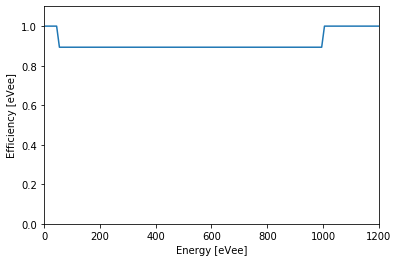

In [590]:
#Efficiency is 1 outside of 50-1000 eV and 
eff0=dNeff(dN_cut,data['PuBe']['p'])
effhi=dNeff(dN_cut,data['PuBe']['p']-data['PuBe']['dp'])
efflow=dNeff(dN_cut,data['PuBe']['p']+data['PuBe']['dp'])
print(f"eff: {eff0:.4f} +{effhi-eff0:.4f} -{eff0-efflow:.4f}")
#eff: 0.8933 +0.0006 -0.0006 elsewhere

#dN cut efficiency
# E: eVee
def eff_dNcut(E):
    eff=np.ones_like(E)
    eff[(E>=50)&(E<1000)]=0.8933
    return eff

def deff_dNcut(E):
    deff=np.zeros_like(E)
    deff[(E>=50)&(E<1000)]=0.0006
    return deff

fill_between(Ebin_ctr,eff_dNcut(Ebin_ctr)-deff_dNcut(Ebin_ctr),eff_dNcut(Ebin_ctr)+deff_dNcut(Ebin_ctr))
plot(Ebin_ctr,eff_dNcut(Ebin_ctr))
xlim(0,1.2e3)
ylim(0,1.1)
xlabel('Energy [eVee]')
ylabel('Efficiency [eVee]');

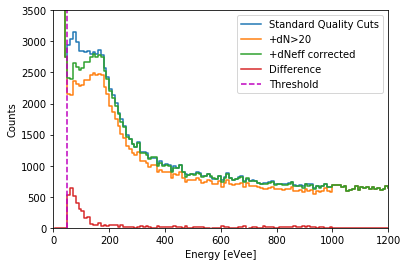

In [588]:
c0,b=np.histogram(1e3*data[dtype]['PTOFkeV'],bins=Ebins)
step(Ebin_ctr,c0,where='mid',label='Standard Quality Cuts')

c,b=np.histogram(1e3*data[dtype]['PTOFkeV'][cut],bins=Ebins)
step(Ebin_ctr,c,where='mid',label=f'+dN>{dN_cut:.0f}')

step(Ebin_ctr,c/eff_dNcut(Ebin_ctr),where='mid',label='+dNeff corrected')

step(Ebin_ctr,c0-c/eff_dNcut(Ebin_ctr),where='mid',label='Difference')

axvline(50,linestyle='--',color='m',label='Threshold')

ylim(0,3500)
xlim(0,1.2e3)
xlabel('Energy [eVee]')
ylabel('Counts')
legend()

In [580]:
#Estimated leakage in 50-1000eV
cut=((data['PuBe']['in50_1000']==1) & (data['PuBe']['dN_pre']>dN_cut) & (data['PuBe']['dN_post']>dN_cut))
dN_Npass=np.sum(cut)
print(f'dN_Npass:\t{dN_Npass}')

dNgood_Npass=data['PuBe']['NdN_good']*dNeff(dN_cut,data[dtype]['p'])

#Calc uncertainties
ArelErr=data['PuBe']['dp']/data['PuBe']['p']
dNgood_Npass_low=data['PuBe']['NdN_good']*(1-ArelErr)*dNeff(dN_cut,data['PuBe']['p']-data['PuBe']['dp'])
dNgood_Npass_hi=data['PuBe']['NdN_good']*(1+ArelErr)*dNeff(dN_cut,data['PuBe']['p']+data['PuBe']['dp'])

#Combine stat and fit uncertainties
ddNgood_Npass_stat = np.sqrt(data['PuBe']['NdN_good'])*dNeff(dN_cut,data[dtype]['p'])
ddNgood_Npass_fit = np.abs(dNgood_Npass_hi-dNgood_Npass_low)/2#Make it symmetric
ddNgood_Npass = np.sqrt(ddNgood_Npass_stat**2 + ddNgood_Npass_fit**2)

print(f'dNgood_Npass:\t{dNgood_Npass:.0f} ± {ddNgood_Npass:.0f}')

#Fraction
fleak=100*(dN_Npass-dNgood_Npass)/dN_Npass
dfleak=100*dNgood_Npass/dN_Npass*np.sqrt( (ddNgood_Npass/dNgood_Npass)**2 + abs(1/dN_Npass) )

print(f'f_leak:\t{fleak:.2f}% ± {dfleak:.2f}%')

dN_Npass:	101798
dNgood_Npass:	101729 ± 581
f_leak:	0.07% ± 0.65%


# Higher Energy

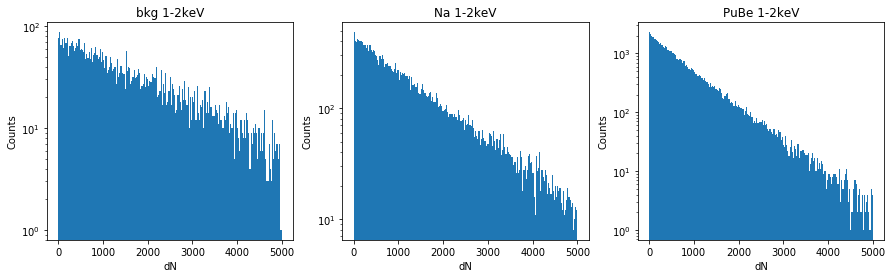

In [38]:
#For comparison, what's the higher energy dN distributions look like?
fig,axs=subplots(1,3,figsize=(15,4))
for i,dtype in enumerate(data_types):
    ecut=(data[dtype]['PTOFkeV']>1)
    
    axs[i].hist(np.diff(data[dtype]['Entry'][ecut]),bins=np.linspace(0,5e3,200))
    axs[i].set_title(f'{dtype} 1-2keV')
    axs[i].set_xlabel('dN')
    axs[i].set_ylabel('Counts')
    axs[i].set_yscale('log')

# Binomial Toy Models

In [ ]:
#For finite chains, the expectation values are a little different
# from the PMF above


In [283]:
#Small sim to test fitting bias
p=6e-4

#Ns=np.array([1e5,1e6,1e7,1e8,1e9])
Ns=np.logspace(5,9,9)
ratio_cf=[]
dratio_cf=[]
ratio_bs=[]
dratio_bs=[]
NdNs=[]
for N in tqdm_notebook(Ns):
    dns=1+np.diff(np.where(np.random.random(int(N))<p)[0])
    c,b=np.histogram(dns,bins=np.linspace(0,5e3,401))
    bctr=(b[:-1]+b[1:])/2
    cfit=(bctr>0)
    #popt,perr=fit_bootstrap(fPMF,bctr[cfit],c[cfit],sigmay=np.sqrt(c[cfit]+0.25),p0=[1e5,1e-3],
    #                       Nsigma=1, Nsim=10)
    popt,perr=fit_bootstrap(fPMF,bctr[cfit],c[cfit],sigmay=np.ones_like(c[cfit]),p0=[1e5,1e-3],
                           Nsigma=1, Nsim=10)
    ratio_bs.append(popt[0]/(b[1]-b[0])/len(dns))
    dratio_bs.append(perr[0]/(b[1]-b[0])/len(dns))
    NdNs.append(len(dns))
    
    #popt,pcov=curve_fit(fPMF,bctr[cfit],c[cfit],sigma=np.sqrt(c[cfit]+0.25),absolute_sigma=True,p0=[1e5,1e-3])
    popt,pcov=curve_fit(fPMF,bctr[cfit],c[cfit],p0=[1e5,1e-3])
    perr=np.sqrt(np.diag(pcov))
    ratio_cf.append(popt[0]/(b[1]-b[0])/len(dns))
    dratio_cf.append(perr[0]/(b[1]-b[0])/len(dns))
    
ratio_cf=np.array(ratio_cf)
dratio_cf=np.array(dratio_cf)
ratio_bs=np.array(ratio_bs)
dratio_bs=np.array(dratio_bs)
NdNs=np.array(NdNs)

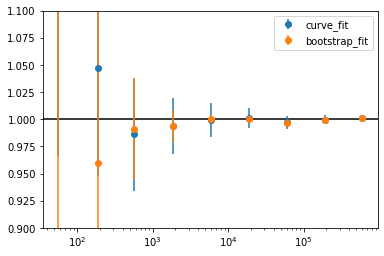

In [301]:
errorbar(NdNs,ratio_cf,yerr=dratio_cf,fmt='o',label='curve_fit')
errorbar(NdNs,ratio_bs,yerr=dratio_bs,fmt='o',label='bootstrap_fit')
xscale('log')
#yscale('log')
ylim(0.9,1.1)
axhline(1,c='k',zorder=0)
legend()

In [326]:
print(np.all((ratio_cf+dratio_cf>1) & (ratio_cf-dratio_cf<1)))
print(np.all((ratio_bs+dratio_bs>1) & (ratio_bs-dratio_bs<1)))

True
False


In [407]:
#Okay, here is a paper that has the exact PMF for a success run of some length in bernoulli trials
#https://doi.org/10.1016/j.camwa.2010.12.023
#Theorem 2.1
#Can try to use that to get a less biased fit
from scipy.special import comb
#Binomial coefficient is comb(N, k, exact=True)
def nCk(n,k):
    return comb(n, k, exact=True)

#Probability of obeserving x runs of length k in a chain of N bernoulli trials
#Hmm, but this has a lot of overflows for large n,k,x's
def PMF_Bern(p,n,k,x):
    q=1-p
    ys=np.arange(n-k*x+1)
    prob=0.0
    for y in ys:
        f1=(p**(n-y))*(q**y)*nCk(y+1,x)
        js=np.arange(int((n-y-k*x)/k))
        f2=0.0
        for j in js:
            f2+=((-1)**j)*nCk(y+1-x,j)*nCk(n-(k+1)*(x+j),n-y-k*(x+j))
        prob+=f1*f2
    return prob

#Expectation value for chain lengths
#Prop 2.1
# p: prob of success
# success: consider chains of successes (True) or failures (False)
def Expect_nk(k,p,n,success=True):
    if success:
        q=1-p
    else:
        q=p
        p=1-p
    
    f1=p**k
    f2=q*p**k*(2+(n-k-1)*q)
    return (n==k)*f1 + (n>=k+1)*f2

#Variance of chain lengths
# p: prob of success
# success: consider chains of successes (True) or failures (False)
def Var_nk(k,p,n,success=True):
    if success:
        q=1-p
    else:
        q=p
        p=1-p
        
    v0=p**k*(1-p**k)
    v1=2*q*p**k - 4*q**2*p**(2*k) + (n-k-1)*q**2*p**k - (n-k-1)**2*q**4*p**(2*k) - 4*(n-k-1)*q**3*p**(2*k)
    v2=v1 + 2*q*p**(2*k)
    v3=2*q*p**k + 2*q**2*p**(2*k) + (n-k-1)*q**2*p**k + 2*(n-4*k-4)*q**3*p**(2*k) - ((n-k-1)**2-(n-2*k-2)*(n-2*k-3))*q**4*p**(2*k)
    return (n==k)*v0 + (n<=2*k)*v1 + (n==2*k+1)*v2 + (n>=2*k+2)*v3

/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


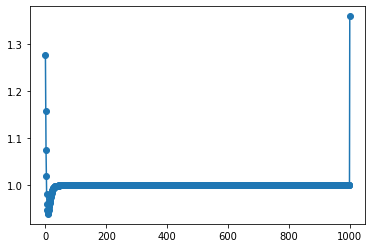

In [400]:
ks=np.arange(2000)
Ess=np.array([Expect_nk(ki,0.8,1000) for ki in ks])
Vars=np.array([Var_nk(ki,0.8,1000) for ki in ks])
#plot(ks,Ess,'-o')
#plot(ks,Vars,'-')
plot(ks,Vars/Ess,'-o')
#yscale('log')

In [408]:
p

0.0006

/home/mastx027/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


[9.988e-01 2.000e+07] [1.63202785e-14 0.00000000e+00]
0.0012,1.6e+06
[9.99415351e-01 1.24001206e+08] [1.32696549e-05 4.44997043e+06]
0.000585,9.92e+06


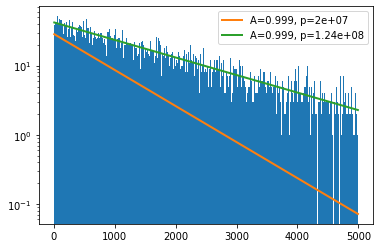

In [409]:
dns=1+np.diff(np.where(np.random.random(int(1e7))<p)[0])
c,b,_=hist(dns,bins=np.linspace(0,5e3,401))
bctr=(b[:-1]+b[1:])/2
db=b[1]-b[0]
cfit=(bctr>0)
popt,perr=fit_bootstrap(Expect_nk,bctr[cfit],c[cfit],sigmay=c[cfit],p0=[1-2*p,2e7],Nsigma=1, Nsim=1000)

print(popt,perr)
print(f'{1-popt[0]:.3g},{popt[1]/db:.3g}')
plot(bctr[cfit],Expect_nk(bctr[cfit],*popt),linewidth=2,label=f'A={popt[0]:.3g}, p={popt[1]:.3g}')


popt,pcov=curve_fit(Expect_nk,bctr[cfit],c[cfit],p0=[1-2*p,2e7])#,sigma=c[cfit]+1,absolute_sigma=True)
perr=np.sqrt(np.diag(pcov))
print(popt,perr)
print(f'{1-popt[0]:.3g},{popt[1]/db:.3g}')
plot(bctr[cfit],Expect_nk(bctr[cfit],*popt),linewidth=2,label=f'A={popt[0]:.3g}, p={popt[1]:.3g}')

yscale('log')
legend()

In [433]:
#Small sim to test fitting bias
p=6e-4

#Ns=np.array([1e5,1e6,1e7,1e8,1e9])
Ns=np.logspace(5,9,9)
ps_pmf=[]
dps_pmf=[]
Ndns_pmf=[]
dNdns_pmf=[]

def Enk(k,p,N):
    return Expect_nk(k,p,N,success=False)

ps_Enk=[]
dps_Enk=[]
Ndns_Enk=[]
dNdns_Enk=[]

NdNs=[]
for N in tqdm_notebook(Ns):
    dns=1+np.diff(np.where(np.random.random(int(N))<p)[0])
    NdNs.append(len(dns))
    
    c,b=np.histogram(dns,bins=np.linspace(0,5e3,401))
    bctr=(b[:-1]+b[1:])/2
    cfit=(bctr>0)

    #PMF
    popt,pcov=curve_fit(fPMF,bctr[cfit],c[cfit],p0=[len(dns),1e-3]) #A,p
    perr=np.sqrt(np.diag(pcov))
    ps_pmf.append(popt[1])
    dps_pmf.append(perr[1])
    Ndns_pmf.append(popt[0]/(b[1]-b[0]))
    dNdns_pmf.append(perr[0]/(b[1]-b[0]))
    

    #Enk
    popt,pcov=curve_fit(Enk,bctr[cfit],c[cfit],p0=[0.9*p,len(dns)/0.9/p]) #p,N
    perr=np.sqrt(np.diag(pcov))
    ps_Enk.append(popt[0])
    dps_Enk.append(perr[0])
    Ndns_Enk.append(popt[0]*popt[1]/(b[1]-b[0]))
    dNdns_Enk.append((popt[0]*popt[1]*np.sqrt((perr[0]/popt[0])**2+(perr[1]/popt[1])**2))/(b[1]-b[0]))

    
ps_pmf=np.array(ps_pmf)
Ndns_pmf=np.array(Ndns_pmf)
dNdns_pmf=np.array(dNdns_pmf)
ps_Enk=np.array(ps_Enk)
Ndns_Enk=np.array(Ndns_Enk)
dNdns_Enk=np.array(dNdns_Enk)
NdNs=np.array(NdNs)

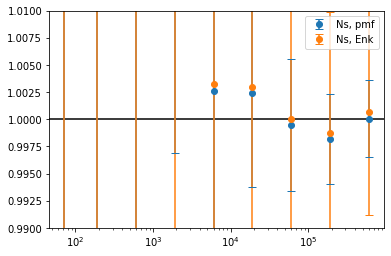

In [434]:
#errorbar(NdNs,ps_pmf/p,yerr=dps_pmf,fmt='o',label='ps, pmf')
#errorbar(NdNs,ps_Enk/p,yerr=dps_Enk,fmt='o',label='ps, Enk')

errorbar(NdNs,Ndns_pmf/NdNs,yerr=dNdns_pmf/NdNs,fmt='o',capsize=4,label='Ns, pmf')
errorbar(NdNs,Ndns_Enk/NdNs,yerr=dNdns_Enk/NdNs,fmt='o',capsize=4,label='Ns, Enk')
#plot(NdNs,Ndns_Enk/Ndns_pmf,'o')
xscale('log')
#yscale('log')
ylim(0.99,1.01)
axhline(1,c='k',zorder=0)
legend()